# Proyecto 7

Área: Medio Ambiente

Descripción: Deberán **modelar** el consumo de agua en una ciudad durante varios meses o años, utilizando diferentes variables. El objetivo es **identificar** patrones de uso, **predecir** la demanda futura y **evaluar** posibles escenarios de escasez mediante **simulaciones**.


## Modelamiento

In [1]:
import numpy as np 
import pandas as pd 
from sklearn.impute import SimpleImputer
from sklearn.neighbors import NearestNeighbors 
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
aguah = pd.read_csv("./AguaH.csv")
aguah.head()
#aguah.info()

,USO2013,TU,DC,M,UL,f.1_ENE_09,f.1_FEB_09,f.1_MAR_09,f.1_ABR_09,f.1_MAY_09,...,f.1_MAR_15,f.1_ABR_15,f.1_MAY_15,f.1_JUN_15,f.1_JUL_15,f.1_AGO_15,f.1_SEP_15,f.1_OCT_15,f.1_NOV_15,f.1_DIC_15
0,H3,DOMESTICO MEDIO,0.5,MSDELAUNET,197.0,20.0,20.0,20.0,20.0,20.0,...,2.0,1.0,2.0,1.0,7.0,7.0,42.0,27.0,22.0,21.0
1,H3,DOMESTICO MEDIO,0.5,MSDELAUNET,307.0,NaN,30.0,30.0,30.0,30.0,...,11.0,13.0,16.0,14.0,15.0,16.0,13.0,17.0,17.0,11.0
2,H3,DOMESTICO RESIDENCIAL,0.5,MSDELAUNET,179.0,NaN,NaN,NaN,NaN,NaN,...,6.0,9.0,7.0,8.0,8.0,10.0,12.0,9.0,6.0,3.0
3,H3,DOMESTICO MEDIO,0.5,CICASA MMD-15 S,852.0,NaN,NaN,NaN,NaN,NaN,...,17.0,20.0,16.0,16.0,18.0,18.0,17.0,17.0,18.0,9.0
4,H3,DOMESTICO RESIDENCIAL,0.5,NaN,NaN,20.0,20.0,20.0,20.0,20.0,...,27.0,27.0,27.0,28.0,28.0,31.0,27.0,27.0,27.0,24.0


In [3]:
lookup = {'ENE':'01','FEB':'02','MAR':'03','ABR':'04','MAY':'05','JUN':'06','JUL':'07','AGO':'08','SEP':'09','OCT':'10','NOV':'11','DIC':'12'}
clist=[]
for col in aguah.columns[5:]:
    col = col[4:].split('_')
    clist.append('20'+col[1]+'-'+lookup[col[0]])

columns = ['LANDUSE_TYPE','USER','PIPE DIAM','VENDOR','JAN16']+clist
aguah.columns=columns
aguah.head()

,LANDUSE_TYPE,USER,PIPE DIAM,VENDOR,JAN16,2009-01,2009-02,2009-03,2009-04,2009-05,...,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12
0,H3,DOMESTICO MEDIO,0.5,MSDELAUNET,197.0,20.0,20.0,20.0,20.0,20.0,...,2.0,1.0,2.0,1.0,7.0,7.0,42.0,27.0,22.0,21.0
1,H3,DOMESTICO MEDIO,0.5,MSDELAUNET,307.0,NaN,30.0,30.0,30.0,30.0,...,11.0,13.0,16.0,14.0,15.0,16.0,13.0,17.0,17.0,11.0
2,H3,DOMESTICO RESIDENCIAL,0.5,MSDELAUNET,179.0,NaN,NaN,NaN,NaN,NaN,...,6.0,9.0,7.0,8.0,8.0,10.0,12.0,9.0,6.0,3.0
3,H3,DOMESTICO MEDIO,0.5,CICASA MMD-15 S,852.0,NaN,NaN,NaN,NaN,NaN,...,17.0,20.0,16.0,16.0,18.0,18.0,17.0,17.0,18.0,9.0
4,H3,DOMESTICO RESIDENCIAL,0.5,NaN,NaN,20.0,20.0,20.0,20.0,20.0,...,27.0,27.0,27.0,28.0,28.0,31.0,27.0,27.0,27.0,24.0


The proportion of entries with non-NaN values is 79.06%


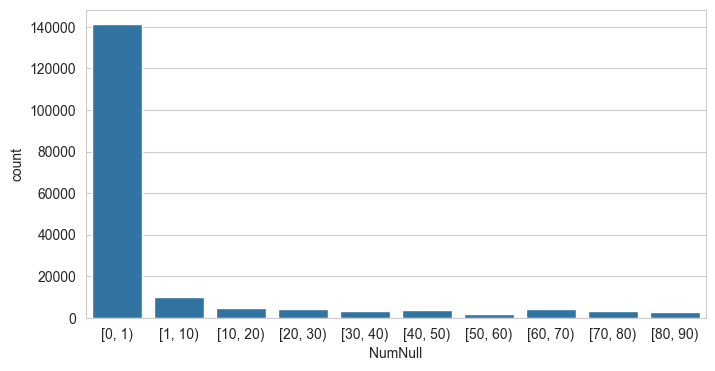

In [ ]:
cons = aguah.iloc[0:, 5:]
cons['NumNull'] = cons.isnull().sum(axis=1)
print('The proportion of entries with non-NaN values is {:.2f}%'.format(len(cons[cons.NumNull==0])/len(cons)*100))
bins = [0,1,10,20,30,40,50,60,70,80,90]
cut = pd.cut(cons.NumNull, bins=bins, include_lowest=True, right=False)
fig, axis1 = plt.subplots(1,figsize=(8,4))
sns.countplot(x=cut, data=cut.to_frame(), ax=axis1)
plt.show()

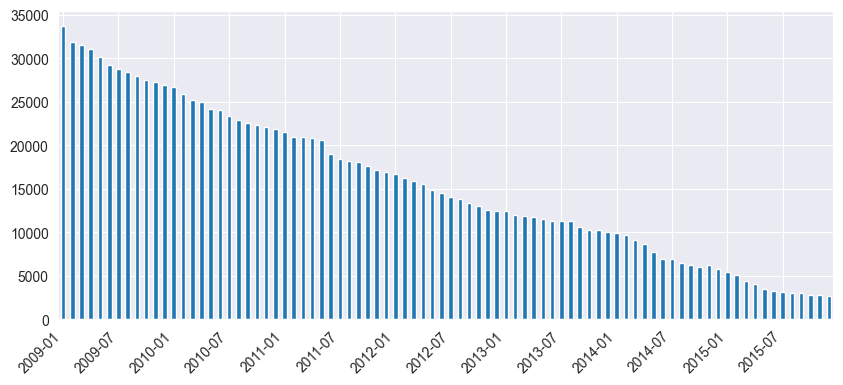

In [ ]:
NumNullwithTime = cons.drop('NumNull', axis=1).isnull().sum()

sns.set_style("darkgrid")
plt.figure(figsize=(10,4))
pbar = NumNullwithTime.plot.bar()
plt.xticks(list(range(0,len(NumNullwithTime.index),6)), list(NumNullwithTime.index[0::6]), rotation=45, ha='right')
plt.show()

In [13]:
## Return index of column (0-83) where the first non-NA number appears. If none, return 84
def FirstNonNull(row):
    count=0
    for col in row:
        if col==False: return count
        else: count = count+1
    return count

## Return index of column (0-83) where the last non-NA number appears, If none, return -1
def LastNonNull(row):
    count=0
    flag=-1
    for col in row:
        if col==False:
            flag=count
            count=count+1
        else: count=count+1
    return flag

In [14]:
## I need this function for the cases of all NaN entries (NullinService value becomes 0 from -83)
def Setzero(x):
    if x<0: return 0
    else: return x

## Number of NaN values before service period
groupnull = aguah.iloc[:,0:5]
groupnull = pd.concat([groupnull, cons], axis=1)

groupnull['FirstNonNull'] = cons.copy().drop(['NumNull'], axis=1).isnull().apply(FirstNonNull,axis=1)
groupnull['LastNonNull'] = cons.copy().drop(['NumNull'],axis=1).isnull().apply(LastNonNull,axis=1)
groupnull['NullInService'] = groupnull.NumNull - groupnull.FirstNonNull - (len(cons.columns)-1-groupnull.LastNonNull) +1    
groupnull['NullInService'] = groupnull['NullInService'].apply(Setzero)
groupnull.NullInService.value_counts(sort=False).head(6) ## Print only head values

NullInService
0     173773
1       3894
2        489
3        197
4         80
75         1
Name: count, dtype: int64

In [15]:
contLong = groupnull[groupnull.NumNull==0]
contShort = groupnull[(groupnull.NumNull>0) & (groupnull.NullInService==0)]
interupted = groupnull[(groupnull.NullInService)>0]
print('Length of 3 groups: (Non-NA Group, Edge-NA Group, Interupted Group) = ({}, {}, {})'.format(len(contLong), len(contShort), len(interupted)))

Length of 3 groups: (Non-NA Group, Edge-NA Group, Interupted Group) = (141205, 32568, 4824)
